# Properati - Data Preparation and Exploration

**Content of this notebook:**
1. Preparation of the dataset
    - Properati dataset
    - Neighbourhoods dataset
    - Metro stations dataset
2. Feature Engineering
3. Data exploration

*For the data modelling, please see the notebook called 'Properati - Modelling'.*

## 1. Preparation of the dataset

Importing the libraries used in this notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import unidecode
import re
from math import radians, cos, sin, asin, sqrt
import pickle
import geopandas as gpd
from shapely.geometry import Polygon, Point
import shapely.wkt

### 1.1 Properati dataset

Reading the data into a Pandas DataFrame and a first exploration of the dataset.

In [2]:
properati = pd.read_csv('ar_properties.csv.gz')

In [3]:
properati.shape

(1000000, 25)

In [4]:
properati.columns

Index(['id', 'ad_type', 'start_date', 'end_date', 'created_on', 'lat', 'lon',
       'l1', 'l2', 'l3', 'l4', 'l5', 'l6', 'rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'surface_covered', 'price', 'currency', 'price_period',
       'title', 'description', 'property_type', 'operation_type'],
      dtype='object')

It is not clear to me what the content is of some columns. I will check out the unique values in these columns.

In [5]:
properati.l1.unique()

array(['Argentina', 'Uruguay', 'Estados Unidos', 'Brasil'], dtype=object)

Columns 'l1' contains countries. I will filter out countries other than Argentina.

In [6]:
caba = properati[properati.l1 == 'Argentina'].copy()

In [7]:
properati.l2.unique()

array(['Chaco', 'Salta', 'Chubut', 'Colonia', 'Florida', 'Mendoza',
       'Córdoba', 'La Pampa', 'La Rioja', 'Misiones', 'Neuquén',
       'Santa Fe', 'Tucumán', 'Canelones', 'Maldonado', 'Montevideo',
       'Río Negro', 'Entre Ríos', 'Capital Federal',
       'Buenos Aires Interior', 'Bs.As. G.B.A. Zona Sur',
       'Bs.As. G.B.A. Zona Norte', 'Bs.As. G.B.A. Zona Oeste',
       'Buenos Aires Costa Atlántica', 'Jujuy', 'Pennsylvania',
       'Maryland', 'San Juan', 'San Luis', 'Santa Cruz', 'Formosa',
       'Rocha', 'Santa Catarina', 'Corrientes', 'Michigan',
       'Tierra Del Fuego', 'Santiago Del Estero', 'Catamarca', 'Miami',
       'Rio de Janeiro', 'Rio Grande do Norte'], dtype=object)

In [8]:
properati.l3.unique()

array(['Resistencia', 'Salta', 'Cushamen', ..., 'Garuhapé', 'El Soberbio',
       'Limay Centro'], dtype=object)

In [9]:
properati.l4.unique()

array([nan, 'Nueva Córdoba', 'Alta Córdoba', 'Playa Brava',
       'Palermo Soho', 'Palermo Hollywood', 'Palermo Chico',
       'Barrio Santa Irene - Comarcas de Luján', 'City Bell',
       'Manuel B Gonnet', 'La Plata', 'Wilde',
       'Barrio Cerrado El Lauquén', 'Burzaco', 'Jose Marmol', 'Adrogué',
       'Luis Guillón', 'Remedios de Escalada', 'Monte Grande', 'Lanús',
       'Lomas de Zamora', 'Canning', 'Ezeiza', 'Berazategui', 'Banfield',
       'Villa Rosa', 'Nordelta', 'Barrio San Rafael', 'Villa Adelina',
       'San Isidro', 'Martínez', 'Jose Leon Suarez',
       'Ingeniero Pablo Nogués', 'Belén de Escobar', 'Olivos',
       'La Lucila', 'San Martín', 'Pilar', 'Septiembre',
       'Rincón de Milberg', 'Victoria', 'Villa Ballester',
       'Boulogne Sur Mer', 'San Fernando', 'Florida', 'San Miguel',
       'Tortuguitas', 'Beccar', 'Santa María de los Olivos',
       'General Pacheco', 'Billinghurst', 'Carapachay', 'Villa Martelli',
       'Paso del Rey', 'Ciudad Jardín Lomas d

In [10]:
properati.l5.unique()

array([nan, 'Barrio Las Caletas', 'Barrio Los Sauces', 'BarrioPortezuelo',
       'Barrio Los Castores', 'Barrio Barrancas del Lago',
       'Barrio El Yacht', 'QBay Yacht', 'Barrio Los Alisos',
       'Barrio Lagos del Golf 2', 'Barrio Los Tilos', 'Barrio El Golf',
       'Barrio Las Glorietas', 'Barrio Los Lagos', 'Barrio La Isla',
       'Barrio Cabos del Lago', 'Enyoi', 'Barrio Residencial Pacheco 2',
       'Barrio Residencial Pacheco 1', 'Islas del Canal',
       'Barrio Lagos del Golf 1', 'Barrio La Alameda'], dtype=object)

In [11]:
properati.l6.unique()

array([nan])

In [12]:
properati.ad_type.unique()

array(['Propiedad'], dtype=object)

In [13]:
properati.operation_type.unique()

array(['Venta', 'Alquiler', 'Alquiler temporal'], dtype=object)

I am only interested in the properties in the city of Buenos Aires that are for sale. Therefore I will filter out all properties with a different location and all properties that are for rent.

In [14]:
caba = properati[properati.l2 == 'Capital Federal'].copy()
caba = caba[caba.operation_type == 'Venta'].copy()

Some of the filtered properties, are still located outside of Buenos Aires (based on their latitude and longitude). I remove these properties from the dataset.

In [15]:
caba = caba.drop(caba[caba.lat>-34.525].index)
caba = caba.drop(caba[caba.lat<-34.750].index)
caba = caba.drop(caba[caba.lon>-58.350].index)
caba = caba.drop(caba[caba.lon<-58.525].index)

I will change the data type of the columns containing dates. To be able to do so, first I need to replace an incorrect date in the 'end_date' column by NaN.

In [16]:
caba.end_date.replace('9999-12-31', np.nan, inplace=True)

caba.loc[:, 'start_date'] = pd.to_datetime(caba.start_date)
caba.loc[:, 'end_date'] = pd.to_datetime(caba.end_date)
caba.loc[:, 'created_on'] = pd.to_datetime(caba.created_on)

In [17]:
caba.dtypes

id                         object
ad_type                    object
start_date         datetime64[ns]
end_date           datetime64[ns]
created_on         datetime64[ns]
lat                       float64
lon                       float64
l1                         object
l2                         object
l3                         object
l4                         object
l5                         object
l6                        float64
rooms                     float64
bedrooms                  float64
bathrooms                 float64
surface_total             float64
surface_covered           float64
price                     float64
currency                   object
price_period               object
title                      object
description                object
property_type              object
operation_type             object
dtype: object

I will drop the columns that have no added value for this project. This leaves me with a total of 17 columns.

In [18]:
caba.drop(columns=['ad_type', 'l1', 'l2', 'l4','l5', 'l6', 'price_period', 'operation_type'], inplace=True)

In [19]:
caba.shape

(179876, 17)

I rename the column 'l3' to 'neighbourhood', so the content of the columns is more clear.

In [20]:
caba = caba.rename(columns={'l3':'neighbourhood'})

In [21]:
caba.neighbourhood.unique()

array(['Nuñez', 'Retiro', 'Caballito', 'Chacarita', 'Monte Castro',
       'San Nicolás', 'Velez Sarsfield', 'Villa del Parque',
       'Villa General Mitre', 'Palermo', 'Belgrano', 'Monserrat',
       'Villa Crespo', 'Once', 'Boedo', 'Almagro', 'Recoleta',
       'Balvanera', 'Barrio Norte', 'Villa Devoto', 'Constitución',
       'Villa Santa Rita', 'Congreso', 'Floresta', 'San Cristobal',
       'Villa Urquiza', 'Flores', 'Colegiales', 'Parque Avellaneda',
       'Villa Luro', 'Liniers', 'Tribunales', 'Villa Lugano',
       'Villa Ortuzar', 'Saavedra', 'San Telmo', 'Versalles',
       'Villa Pueyrredón', 'Coghlan', 'Barracas', 'Puerto Madero',
       'Parque Chacabuco', 'Mataderos', 'Parque Patricios', 'Abasto', nan,
       'Boca', 'Parque Centenario', 'Centro / Microcentro', 'Paternal',
       'Las Cañitas', 'Pompeya', 'Parque Chas', 'Agronomía',
       'Villa Soldati', 'Villa Real', 'Catalinas', 'Villa Riachuelo',
       'Distrito Audiovisual'], dtype=object)

Checking out the amount of missing values.

In [22]:
pd.DataFrame({'missing':caba.isnull().sum(), 'percentage':(caba.isnull().sum()/caba.shape[0]).round(2)})

,missing,percentage
id,0,0.00
start_date,0,0.00
end_date,32892,0.18
created_on,0,0.00
lat,25720,0.14
lon,25825,0.14
neighbourhood,18865,0.10
rooms,60492,0.34
bedrooms,93011,0.52
bathrooms,28279,0.16


The price, latitude, longtitude and surface columns are essential for the purpose of this project. Since the dataset is big enough, I decided to delete the rows with missing values in these columns. But first I will try to fill some missing values of the total surface columns with the values in the covered surface columns.

Later in this section I will complete/impute the missing values of neighbourhood, rooms, bedrooms and bathrooms.

In [23]:
caba.surface_total.fillna(caba.surface_covered, inplace=True)

caba = caba.dropna(how='any', subset=['price', 'currency', 'lat', 'lon', 'surface_total', 'surface_covered'])

The price columns contains a mix of prices in dollars and pesos. I will create a new column with all prices converted into dollars


In [24]:
print('Currencies in price columns:', caba.currency.unique())
print('Oldest creations date:', caba.created_on.min())
print('Newest creations date:', caba.created_on.max())

Currencies in price columns: ['USD' 'ARS']
Oldest creations date: 2019-06-10 00:00:00
Newest creations date: 2020-07-03 00:00:00


To help me convert the prices into dollars I will use a small table with exchange rates from June 2019 until July 2020.

In [25]:
exchange_rate = pd.read_csv('exchange_rate.csv', sep=';')

In [26]:
exchange_rate

,Year,Month_name,Month_number,Exchange_rate
0,2019,June,6,43.7894
1,2019,July,7,42.5434
2,2019,August,8,52.7271
3,2019,September,9,56.5014
4,2019,October,10,58.5308
5,2019,November,11,59.7381
6,2019,December,12,59.8832
7,2020,January,1,60.0110
8,2020,February,2,61.3484
9,2020,March,3,63.1227


To be able to link the montly exchange rates to the properati dataframe, I will add two columns to the properati dataset with the creation year and month. Then I merge both dataframes on this information.

In [27]:
caba['created_on_year'] = [x.year for x in caba.created_on]
caba['created_on_month'] = [x.month for x in caba.created_on]

caba = pd.merge(caba, exchange_rate,  how='left', left_on=['created_on_year','created_on_month'],\
                                                  right_on = ['Year','Month_number'])

I will create a new column with prices in US dollars.

In [28]:
caba['price_usd'] = caba['price'].copy()
caba.loc[caba.currency=='ARS', 'price_usd'] = caba['price']/caba['Exchange_rate']

I will create a new column for the price per m2 (covered) in USD.

In [29]:
caba['price_m2_covered'] = caba['price_usd']/caba['surface_covered']

I would like to differentiate between two general property types: houses and apartments. This will allow me to more easily compare the property types in the Airbnb dataset with the property types in the Properati dataset.

First I will filter out any property types other than houses and apartments, and then I will create a new column with only the categories 'apartment' and 'house'.

In [30]:
caba.property_type.unique()

array(['Casa', 'Local comercial', 'Departamento', 'Oficina', 'PH',
       'Cochera', 'Lote', 'Otro', 'Depósito', 'Casa de campo'],
      dtype=object)

In [31]:
apartments = ['Departamento', 'PH']
houses = ['Casa', 'Casa de campo']

caba = caba[(caba.property_type.isin(apartments))|(caba.property_type.isin(houses))].copy()

caba['property_type_general'] = ['apartment' if x in apartments else 'house' for x in caba.property_type]

To complete the rooms column, first I try to fill some missing values by taking the amount of bedrooms + 1. After, I will fill the remaining missing values with an imputation based on the average amount of rooms for properties with the same neighbourhood, property type and a similar surface.

In [32]:
caba['rooms'].fillna((caba['bedrooms']+1), inplace=True)

In [33]:
caba['surface_category'] = np.nan
caba.loc[caba.surface_covered<=30, 'surface_category'] = '<=30'
caba.loc[(caba.surface_covered>30)&(caba.surface_covered<=50), 'surface_category'] = '30-50'
caba.loc[(caba.surface_covered>50)&(caba.surface_covered<=100), 'surface_category'] = '50-100'
caba.loc[(caba.surface_covered>100)&(caba.surface_covered<=200), 'surface_category'] = '100-200'
caba.loc[(caba.surface_covered>200)&(caba.surface_covered<=300), 'surface_category'] = '200-300'
caba.loc[(caba.surface_covered>300)&(caba.surface_covered<=500), 'surface_category'] = '300-500'
caba.loc[(caba.surface_covered>500), 'surface_category'] = '>500'

rooms = pd.DataFrame(caba.groupby(['neighbourhood', 'property_type_general', 'surface_category'])['rooms'].mean().round())
rooms.rename(columns={'rooms': 'rooms_average'},inplace=True)
caba = caba.merge(rooms, how='left', on=['neighbourhood', 'property_type_general', 'surface_category'])

caba['rooms'].fillna(caba['rooms_average'], inplace=True)

I will fill the missing values in the bathrooms column in the same way.

In [34]:
bathrooms = pd.DataFrame(caba.groupby(['neighbourhood', 'property_type_general', 'surface_category'])['bathrooms'].mean().round())
bathrooms.rename(columns={'bathrooms': 'bathrooms_average'},inplace=True)
caba = caba.merge(bathrooms, how='left', on=['neighbourhood', 'property_type_general', 'surface_category'])

caba['bathrooms'].fillna(caba['bathrooms_average'], inplace=True)

I will use the rooms column to fill the missing values in the bedrooms columns. As a general rule I will use  "bedrooms = rooms - 1",  but in case the amount of rooms is 1, than I will use "bedrooms = rooms".

In [35]:
caba.loc[caba.rooms>1, 'bedrooms'] = caba.loc[caba.rooms>1, 'bedrooms'].fillna(caba.rooms-1)
caba.loc[caba.rooms==1, 'bedrooms'] = caba.loc[caba.rooms==1, 'bedrooms'].fillna(caba.rooms)

Finally I will remove the few lines that remain with missing values for rooms, bedrooms or bathrooms

In [36]:
caba = caba.dropna(subset=['rooms', 'bedrooms', 'bathrooms'])

A first exploration of the numerical features.

In [37]:
caba.drop(columns=['lat', 'lon', 'created_on_year', 'created_on_month', 'Year', 'Month_number']).describe().round(1)

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,Exchange_rate,price_usd,price_m2_covered,rooms_average,bathrooms_average
count,91679.0,91679.0,91679.0,91679.0,91679.0,91679.0,91679.0,91679.0,91679.0,91673.0,91673.0
mean,2.8,1.9,1.5,109.3,92.2,300880.8,58.8,246237.7,3190.9,2.8,1.4
std,1.4,1.2,0.8,907.3,795.0,1044517.9,7.5,336779.3,6667.3,1.1,0.7
min,1.0,0.0,1.0,1.0,1.0,5000.0,42.5,3824.1,1.7,1.0,1.0
25%,2.0,1.0,1.0,44.0,40.0,112800.0,56.5,112000.0,2317.1,2.0,1.0
50%,3.0,2.0,1.0,65.0,58.0,165000.0,59.9,165000.0,2857.1,3.0,1.0
75%,4.0,3.0,2.0,104.0,90.0,265000.0,63.1,260000.0,3507.2,3.0,2.0
max,38.0,37.0,18.0,126062.0,126062.0,111111111.0,71.5,32434232.0,754284.5,18.0,8.0


There seem to be some very big outliers in the price, surface and amount of rooms. At the same time there are some very low prices and small surfaces that seem incorrect.

I will remove the properties with more than 5 bedrooms or bathrooms, because for the purpose of this project I do not want to include any hotel/hostel-like properties.

In [38]:
caba.drop(labels=caba[caba.bedrooms>5].index, inplace=True)
caba.drop(labels=caba[caba.bathrooms>5].index, inplace=True)
caba.drop(labels=caba[caba.rooms>10].index, inplace=True)

There are rows where the total surface is smaller than the covered surface, which is not possible. After inspecting the data it seems that the values in these rows are mistakenly reversed. I will correct this.

In [39]:
surface_total_copy = caba['surface_total'].copy()
surface_covered_copy = caba['surface_covered'].copy()

conditions = [(surface_total_copy<surface_covered_copy),(surface_total_copy>surface_covered_copy)]

choices1 = [surface_covered_copy ,surface_total_copy]
choices2 = [surface_total_copy, surface_covered_copy]

caba['surface_total'] = np.select(conditions, choices1, caba['surface_total'])
caba['surface_covered'] = np.select(conditions, choices2, caba['surface_covered'])

I will remove some properties from the dataset with very extreme surface values (a covered surface bigger than 500 m2 for apartments and bigger than 1000 m2 for houses, and a total surface bigger than 600 m2 for apartments and bigger than 2000 m2 for houses).

In [40]:
caba = caba.drop(caba.loc[(caba.surface_covered>500)&(caba.property_type_general=='apartment')].index)
caba = caba.drop(caba.loc[(caba.surface_covered>1000)&(caba.property_type_general=='house')].index)
caba = caba.drop(caba.loc[(caba.surface_total>600)&(caba.property_type_general=='apartment')].index)
caba = caba.drop(caba.loc[(caba.surface_total>2000)&(caba.property_type_general=='house')].index)

I will remove rows with surfaces smaller than 10 m2. These values must be incorrect.

In [41]:
caba = caba.drop(caba.loc[caba['surface_total'] < 10].index)
caba = caba.drop(caba.loc[caba['surface_covered'] < 10].index)

I will remove properties with extreme prices (lower than USD 10.000 or higher than USD 2.000.000).

In [42]:
caba = caba.drop(caba.loc[caba.price_usd<10000].index)
caba = caba.drop(caba.loc[caba.price_usd>2000000].index)

I will remove properties with extreme prices per m2 (lower than USD 500/m2 or higher than USD 10.000/m2).

In [43]:
caba = caba.drop(caba.loc[caba.price_m2_covered<500].index)
caba = caba.drop(caba.loc[caba.price_m2_covered>10000].index)

In [44]:
caba.drop(columns=['lat', 'lon', 'created_on_year', 'created_on_month', 'Year', 'Month_number']).describe().round(1)

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,Exchange_rate,price_usd,price_m2_covered,rooms_average,bathrooms_average
count,89651.0,89651.0,89651.0,89651.0,89651.0,89651.0,89651.0,89651.0,89651.0,89645.0,89645.0
mean,2.7,1.8,1.4,87.2,74.5,276651.9,58.8,224438.3,3012.3,2.7,1.3
std,1.2,1.0,0.7,73.0,55.1,873231.7,7.5,204850.7,1052.6,1.0,0.6
min,1.0,0.0,1.0,11.0,10.0,13167.0,42.5,13167.0,506.2,1.0,1.0
25%,2.0,1.0,1.0,44.0,40.0,112000.0,56.5,111000.0,2333.3,2.0,1.0
50%,3.0,2.0,1.0,65.0,57.0,163001.0,59.9,161000.0,2862.7,3.0,1.0
75%,4.0,2.0,2.0,100.0,87.0,259000.0,63.1,255000.0,3500.0,3.0,2.0
max,10.0,5.0,5.0,2000.0,1000.0,55000000.0,71.5,2000000.0,10000.0,15.0,6.0


### 1.2 Neighbourhoods dataset

Reading the neighbourhoods dataset.

In [45]:
neighbourhoods = pd.read_csv('barrios.csv', encoding='latin1')

In this dataset the location information is saved in WKT format. First I apply the wkt.loads function of Shapely that returns a geometric object from a WKT representation, so that Geopandas is able to read this information. As a coordinate reference system I will use 'epsg:3857'.

In [46]:
neighbourhoods["coordinates"] = neighbourhoods['WKT'].apply(shapely.wkt.loads)
neighbourhoods = gpd.GeoDataFrame(neighbourhoods, geometry='coordinates')
neighbourhoods.crs = 'epsg:3857'

In [47]:
neighbourhoods.head()

,WKT,BARRIO,COMUNA,PERIMETRO,AREA,coordinates
0,"POLYGON ((-58.4528200492791 -34.5959886570639,...",CHACARITA,15.0,7725.695228,3.118101e+06,"POLYGON ((-58.45282 -34.59599, -58.45366 -34.5..."
1,"POLYGON ((-58.4655768128541 -34.5965577078058,...",PATERNAL,15.0,7087.513295,2.229829e+06,"POLYGON ((-58.46558 -34.59656, -58.46562 -34.5..."
2,"POLYGON ((-58.4237529813037 -34.5978273383243,...",VILLA CRESPO,15.0,8132.699348,3.613584e+06,"POLYGON ((-58.42375 -34.59783, -58.42495 -34.5..."
3,"POLYGON ((-58.4946097568899 -34.6148652395239,...",VILLA DEL PARQUE,11.0,7705.389797,3.399596e+06,"POLYGON ((-58.49461 -34.61487, -58.49479 -34.6..."
4,"POLYGON ((-58.4128700313089 -34.6141162515854,...",ALMAGRO,5.0,8537.901368,4.050752e+06,"POLYGON ((-58.41287 -34.61412, -58.41282 -34.6..."


I will create a Shapely Point object for each Properati listing, a geometric object that Geopandas can read. After I will crate a GeoDataFrame out of the properati dataframe.

In [48]:
points = caba.apply(lambda row: Point(row.lon, row.lat), axis=1)
caba_geo = gpd.GeoDataFrame(caba, geometry=points)
caba_geo.crs = 'epsg:3857'

Below I will plot the points I just created together with the neighbourhood coordinates to check if everything went well.

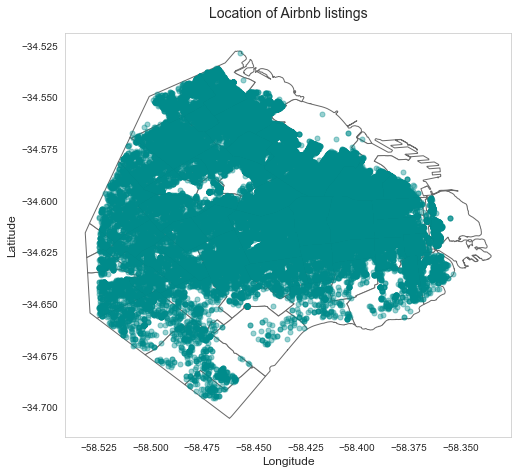

In [49]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect('equal')
neighbourhoods.plot(ax=ax, color='white', edgecolor='dimgrey')
caba_geo.plot(ax=ax, marker='o', color='darkcyan', markersize=25,  alpha=0.4)
plt.title('Location of Airbnb listings', fontsize=14, pad=15)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.grid()
plt.show()

Instead of using the neighbourhood column of the properati dataset, that has more than 5000 missing values and is not objective (people might put an incorrect neighbourhood when they sell their property, because some neighbourhoods sell better or for higher prices than others), in the rest of the project I will use the the barrio column of the neighbourhood dataset.

In [50]:
neighbourhood_and_properati = gpd.sjoin(neighbourhoods, caba_geo, how="left")

In [51]:
caba = pd.merge(caba, neighbourhood_and_properati[['id', 'BARRIO']], how='left', on='id')
caba = caba.dropna(subset=['BARRIO'])

In [52]:
caba['BARRIO'].value_counts()

PALERMO              14118
ALMAGRO               8595
VILLA CRESPO          8437
RECOLETA              6223
CABALLITO             5757
BELGRANO              5097
BALVANERA             4500
VILLA URQUIZA         3002
FLORES                2701
CHACARITA             2257
NUÑEZ                 1844
SAN NICOLAS           1622
COLEGIALES            1611
RETIRO                1603
SAAVEDRA              1473
VILLA DEVOTO          1340
PARQUE CHACABUCO      1336
PUERTO MADERO         1047
MONSERRAT             1031
VILLA DEL PARQUE      1018
SAN CRISTOBAL          957
CONSTITUCION           883
VILLA SANTA RITA       809
BOEDO                  807
VILLA ORTUZAR          797
VILLA GRAL. MITRE      785
BARRACAS               761
MONTE CASTRO           739
COGHLAN                702
VILLA PUEYRREDON       682
MATADEROS              630
LINIERS                586
VELEZ SARSFIELD        575
SAN TELMO              551
FLORESTA               540
BOCA                   533
PATERNAL               525
V

### 1.3 Metro stations dataset

Reading the metro stations dataset. Locally the metro is called the 'subte'.

In [53]:
subtes = pd.read_csv('estaciones-de-subte.csv', encoding='utf8')

I will create a Shapely Point object for each metro station, a geometric object that Geopandas can read. After I will create a GeoDataFrame out of the metro stations dataframe.

In [54]:
points_subtes = subtes.apply(lambda row: Point(row.long, row.lat), axis=1)
subtes_geo = gpd.GeoDataFrame(subtes, geometry=points_subtes)
subtes_geo.crs = 'epsg:3857'

Below I will plot the points of the metro stations together with the neighbourhood coordinates to check if everything went well.

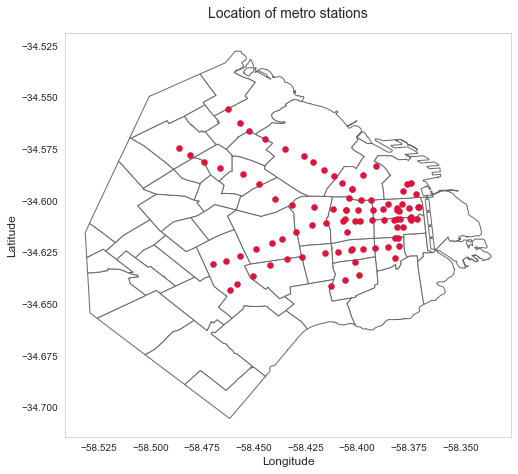

In [55]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect('equal')
neighbourhoods.plot(ax=ax, color='white', edgecolor='dimgrey')
subtes_geo.plot(ax=ax, marker='o', color='crimson', markersize=30,  alpha=1)
plt.title('Location of metro stations', fontsize=14, pad=15)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.grid()
plt.show()

## 2. Feature Engineering

I will create dummy variables for the amenities based on the different amenities found in the description column.

In [56]:
amenities = {'pool': ['pileta', 'piscina'], 'parking': ['garage', 'cochera', 'estacionamiento'],
             'elevator': ['ascensor'], 'gym': ['gimnasio','gym'], 'balcony/patio':['balcon', 'patio'], 
             'garden': ['jardin'], 'terrace':['terraza'], 'bbq': ['parrilla','asador','quincho', 'parrila'], 
             'sum': ['sum']}

def create_dummies(dic, col):
    for key, value in dic.items():
        words = ''
        for x in value:
            words += str(x) + '|'
        words = words[:-1]
        pattern = r'(' + str(words) +')'
        
        regex = re.compile(pattern, flags= re.IGNORECASE)
        caba[key] = caba[col].str.extract(regex, expand = True)
        caba[key] = caba[key].where(caba[key].isnull(), 1).fillna(0).astype(int)
        
caba['description'] = caba['description'].str.lower()
caba['description'] = caba['description'].apply(lambda x: unidecode.unidecode(str(x)))
caba['description'] = caba['description'].apply(lambda x: re.sub(r'([^\s\w]|_)+','',str(x)))

create_dummies(amenities,'description')

I will add a feature with the minimum distance to any metro station, and another feature with the minimum distance to a station of metro line D (this is the metro line that is best connected with most tourist attractions). To calculate the distance between the properati listings and the metro stations, I will use the haversine function.

In [57]:
# source: https://gist.github.com/DeanThompson/d5d745eca4e9023c6501

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [58]:
caba['min_dist_to_subte'] = np.zeros((caba.shape[0]))

for index_caba, id_caba in enumerate(caba.id):
    distances = []
    for index_subte, id_subte in enumerate(subtes.id):
        distances.append(haversine(caba.lon.iloc[index_caba],\
                                   caba.lat.iloc[index_caba],\
                                   subtes.long.iloc[index_subte],\
                                   subtes.lat.iloc[index_subte]))
    min_distance = min(distances)
    caba.loc[caba.id==id_caba, 'min_dist_to_subte'] = min_distance

In [59]:
subte_D = subtes[subtes.linea=='D'].copy()

caba['min_dist_to_subteD'] = np.zeros((caba.shape[0]))

for index_caba, id_caba in enumerate(caba.id):
    distances = []
    for index_subte, id_subte in enumerate(subte_D.id):
        distances.append(haversine(caba.lon.iloc[index_caba],\
                                   caba.lat.iloc[index_caba],\
                                   subte_D.long.iloc[index_subte],\
                                   subte_D.lat.iloc[index_subte]))
    min_distance = min(distances)
    caba.loc[caba.id==id_caba, 'min_dist_to_subteD'] = min_distance

Finally I will create dummies for the neighbourhood, and property type.

In [60]:
dummies = pd.get_dummies(caba[['BARRIO', 'property_type_general']], prefix='',\
                         prefix_sep='', drop_first=True)

In [61]:
caba = pd.concat([caba, dummies], axis=1)

## 3. Data exploration

The figure below shows the distribution of the total property prices in dollars for houses and for apartments. 

We can see that houses tend to have higher prices than apartments. The mayority of the prices for apartments seem to lie somewhere between 50.0000 and 300.000 dollars. The prices of houses vary more. The proportion of houses with prices higher than 300.000 dollars is much bigger than those of apartments.

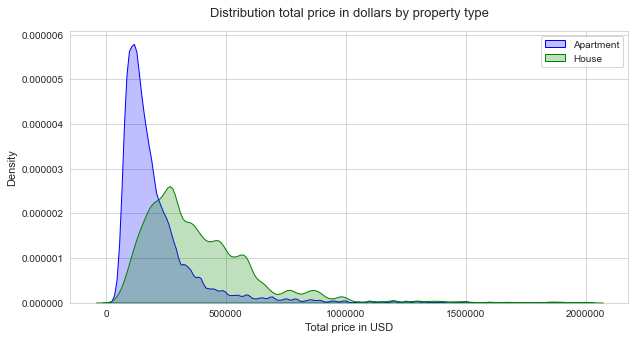

In [62]:
plt.figure(figsize=(10,5))
sns.kdeplot(caba[caba.property_type_general=='apartment'].price_usd, shade=True, color='blue', label='Apartment',
           bw_adjust=0.5)
sns.kdeplot(caba[caba.property_type_general=='house'].price_usd, shade=True, color='green', label='House',
           bw_adjust=0.5)
plt.title('Distribution total price in dollars by property type', fontsize=13, pad=15)
plt.xlabel('Total price in USD', fontsize=11)
plt.ylabel('Density', fontsize=11)
plt.ticklabel_format(style='plain')
plt.legend()

plt.show()

The figure below shows the distribution of the price per m2 for houses and for apartments.

Both distributions have a similar shape, but contrary to the total prices, the price per m2 of apartments tends to be higher than the price per m2 of houses.

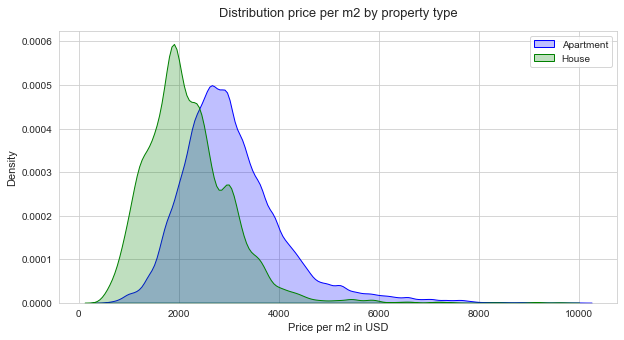

In [63]:
plt.figure(figsize=(10,5))
sns.kdeplot(caba[caba.property_type_general=='apartment'].price_m2_covered, shade=True, color='blue', label='Apartment',
           bw_adjust=0.8)
sns.kdeplot(caba[caba.property_type_general=='house'].price_m2_covered, shade=True, color='green', label='House',
           bw_adjust=0.8)
plt.title('Distribution price per m2 by property type', fontsize=13, pad=15)
plt.xlabel('Price per m2 in USD', fontsize=11)
plt.ylabel('Density', fontsize=11)
plt.legend()

plt.show()

The box plots below show that the total and covered surface of houses is significantly bigger than that of apartments. Therefore it makes intuitive sense that the total price of houses tends to be higher.

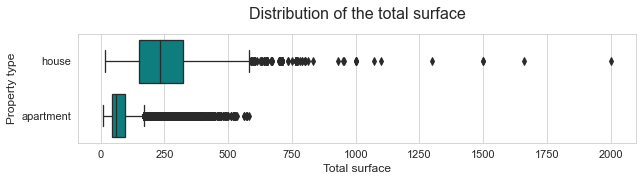

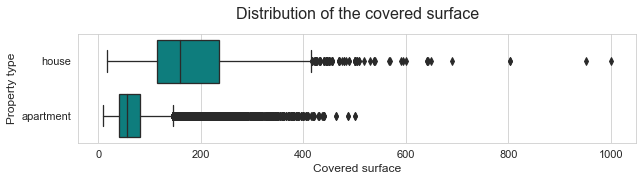

In [64]:
f, ax = plt.subplots(figsize=(10, 2))
ax.set_xscale("linear")
sns.boxplot(x=caba['surface_total'], y=caba['property_type_general'], color='darkcyan', saturation=0.8, linewidth=1.3)
plt.title('Distribution of the total surface', fontsize=16, pad=15)
plt.xlabel('Total surface', fontsize=12)
plt.ylabel('Property type', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.show()

f, ax = plt.subplots(figsize=(10, 2))
ax.set_xscale("linear")
sns.boxplot(x=caba['surface_covered'], y=caba['property_type_general'], color='darkcyan', saturation=0.8, linewidth=1.3)
plt.title('Distribution of the covered surface', fontsize=16, pad=15)
plt.xlabel('Covered surface', fontsize=12)
plt.ylabel('Property type', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.show()

The figure below explores the differences in total property prices per neighbourhood. The graph on the left shows the average property price per neighbourhood and the graph on the right shows the price distribution per neighbourhood. Both are sorted from the largest average price to the lowest.

It is clearly visible that there is one neighbourhood where the property prices are a lot higher than in other neighbourhoods: Puerto Madero.

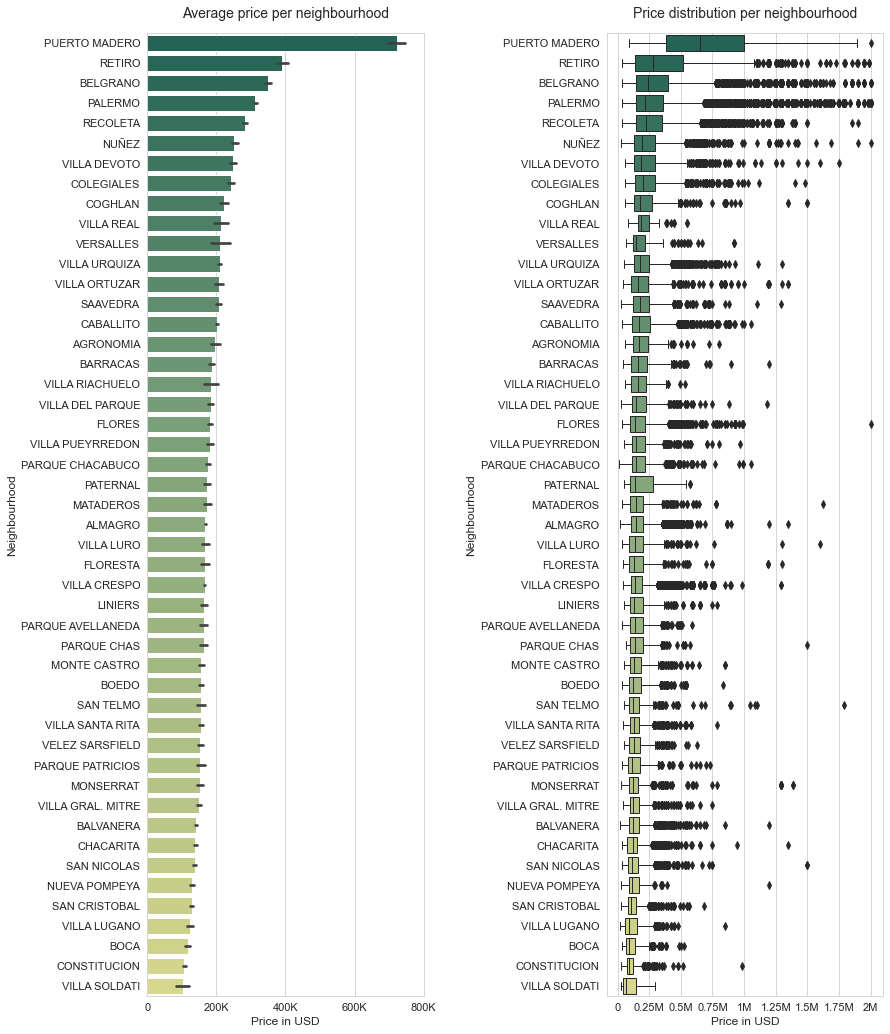

In [65]:
ranks = caba.groupby("BARRIO")["price_usd"].mean().sort_values(ascending=False).index

f = plt.figure(figsize=(13, 15))

ax1 = plt.subplot(121)
sns.barplot(x=caba.price_usd, y=caba.BARRIO, palette='summer', saturation=0.5, ax=ax1, order=ranks)
plt.title('Average price per neighbourhood', fontsize=14, pad=15)
plt.xlabel('Price in USD', fontsize=12)
plt.ylabel('Neighbourhood', fontsize=12)
plt.xticks(ticks=[0, 200000, 400000, 600000, 800000],
           labels=[0, '200K', '400K', '600K', '800K'], 
           fontsize=11)
plt.yticks(fontsize=11)

ax2 = plt.subplot(122)
sns.boxplot(x=caba.price_usd, y=caba.BARRIO, palette='summer', saturation=0.5, ax=ax2, order=ranks, linewidth=1)
plt.title('Price distribution per neighbourhood', fontsize=14, pad=15)
plt.xlabel('Price in USD', fontsize=12)
plt.ylabel('Neighbourhood', fontsize=12)
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(ticks=[0, 250000, 500000, 750000, 1000000, 1250000, 1500000, 1750000, 2000000], 
           labels=[0, '0.25M', '0.5M', '0.75M', '1M', '1.25M', '1.5M', '1.75M', '2M'],
           fontsize=11)
plt.yticks(fontsize=11)

f.tight_layout(pad=3)

plt.show()

The figure below explores the differences in prices per m2 per neighbourhood. The graph on the left shows the average price per m2 per neighbourhood and the graph on the right shows the distribution of the price per m2 per neighbourhood. Both are sorted from the largest average price per m2 to the lowest.

Again, there is clearly one neighbourhood where the prices per m2 are a lot higher than in other neighbourhoods: Puerto Madero.

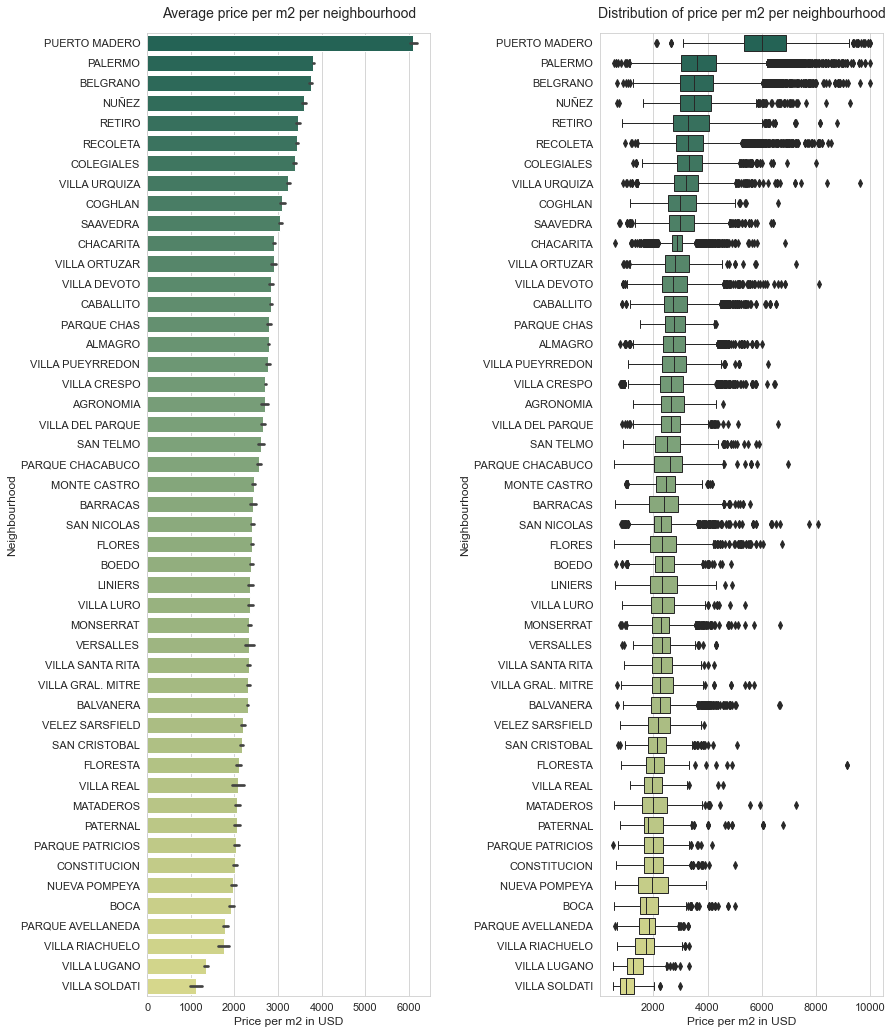

In [66]:
ranks = caba.groupby("BARRIO")["price_m2_covered"].mean().sort_values(ascending=False).index

f = plt.figure(figsize=(13, 15))

ax1 = plt.subplot(121)
sns.barplot(x=caba.price_m2_covered, y=caba.BARRIO, palette='summer', saturation=0.5, ax=ax1, order=ranks)
plt.title('Average price per m2 per neighbourhood', fontsize=14, pad=15)
plt.xlabel('Price per m2 in USD', fontsize=12)
plt.ylabel('Neighbourhood', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

ax2 = plt.subplot(122)
sns.boxplot(x=caba.price_m2_covered, y=caba.BARRIO, palette='summer', saturation=0.5, ax=ax2, order=ranks, linewidth=1)
plt.title('Distribution of price per m2 per neighbourhood', fontsize=14, pad=15)
plt.xlabel('Price per m2 in USD', fontsize=12)
plt.ylabel('Neighbourhood', fontsize=12)
plt.yticks(fontsize=11)
plt.xticks(fontsize=11)
#ax2.set_xlim([0, 210])

f.tight_layout(pad=3)

plt.show()

I will remove the neighbourhoods with less than a 100 rows, because this is not enough data to make generalizations about the neighbourhood.

In [67]:
#neigbourhoods_to_drop = ['VILLA REAL', 'VILLA RIACHUELO', 'VILLA SOLDATI']

#caba = caba.drop(labels=caba[caba.BARRIO.isin(neigbourhoods_to_drop)].index)
#neighbourhood_and_properati = neighbourhood_and_properati.drop(
#    labels=neighbourhood_and_properati[neighbourhood_and_properati.BARRIO.isin(neigbourhoods_to_drop)].index)

I will calculate the average prices per neighbourhood, so I can visualize this data in a choropleth map.

In [68]:
neighbourhood_and_properati['average_price_neighbourhood'] = neighbourhood_and_properati['price_usd'].groupby(
                                                                neighbourhood_and_properati['BARRIO']).transform('mean')
neighbourhood_and_properati['average_price_m2_neighbourhood'] = neighbourhood_and_properati['price_m2_covered'].groupby(
                                                                   neighbourhood_and_properati['BARRIO']).transform('mean')

When comparing the prices per neighbourhood on a map, it seems that prices are highest in the north-east of the city and get lower towards the south. This seems to be the case especially for the price per m2.

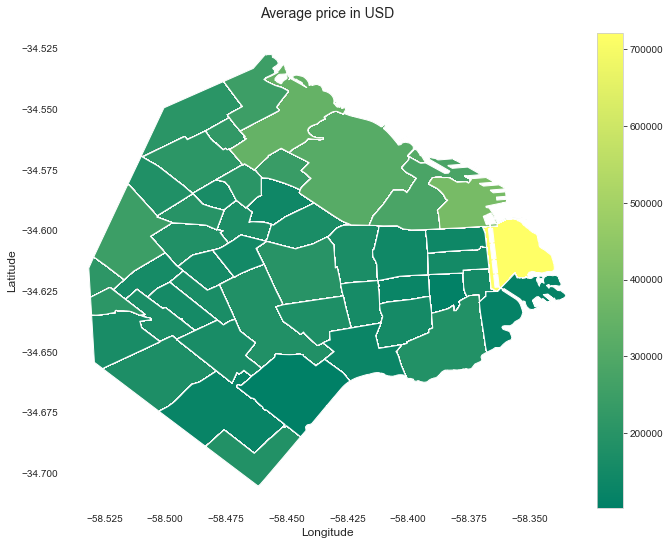

In [69]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(10,10))
neighbourhoods.plot(ax=ax, color='lightgrey', alpha=0.8)
plt.title('Average price in USD', fontsize=14, pad=15)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.grid()
sns.despine(left=True, bottom=True)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
neighbourhood_and_properati.plot(column='average_price_neighbourhood', legend=True, ax=ax, cmap='summer', cax=cax)

plt.show()

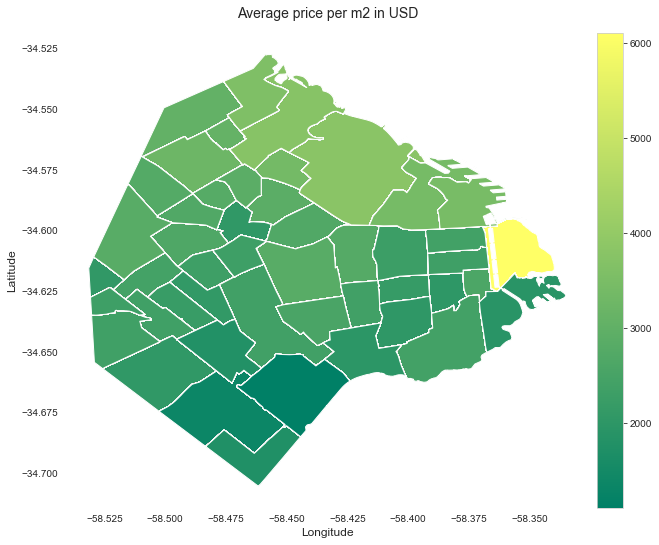

In [70]:
fig, ax = plt.subplots(figsize=(10,10))
neighbourhoods.plot(ax=ax, color='lightgrey', alpha=0.8)
plt.title('Average price per m2 in USD', fontsize=14, pad=15)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.grid()
sns.despine(left=True, bottom=True)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
neighbourhood_and_properati.plot(column='average_price_m2_neighbourhood', legend=True, ax=ax, cmap='summer', cax=cax)

plt.show()

I am interested in seeing the propertion of property types per neighboorhood, to see if there are any significant differences. To do so I will create a dataframe with the count of apartments and houses per neighbourhood. After I will change these counts into percentages with the help of a total column.

In [71]:
# Group the properties by neighbourhood and property type and apply 'count'
prop_types_nbh = caba[['id', 'property_type_general', 'BARRIO']].\
                                        groupby(['BARRIO', 'property_type_general']).count().reset_index()

# Use 'pivot' to move the property types to columns
prop_types_nbh = prop_types_nbh.pivot(index='BARRIO', columns='property_type_general',\
                                                                  values='id')
# Fill any missing values with 0
prop_types_nbh = prop_types_nbh.fillna(0)

# Create a total column
prop_types_nbh['total'] = prop_types_nbh['apartment'] + prop_types_nbh['house']

# Calculate the percentages
prop_types_nbh['apartment'] = prop_types_nbh['apartment']/prop_types_nbh['total']
prop_types_nbh['house'] = prop_types_nbh['house']/prop_types_nbh['total']

In [72]:
prop_types_nbh.head()

property_type_general,apartment,house,total
BARRIO,,,
AGRONOMIA,0.846774,0.153226,248.0
ALMAGRO,0.989296,0.010704,8595.0
BALVANERA,0.992000,0.008000,4500.0
BARRACAS,0.906702,0.093298,761.0
BELGRANO,0.975476,0.024524,5097.0


In the figure below we can see that in all neighbourhoods the majority of the properties are apartment. There are even a couple of neighbourhoods that seem to have (almost) no houses at all on Properati, like Puerto Madero, Retiro and Recoleta.

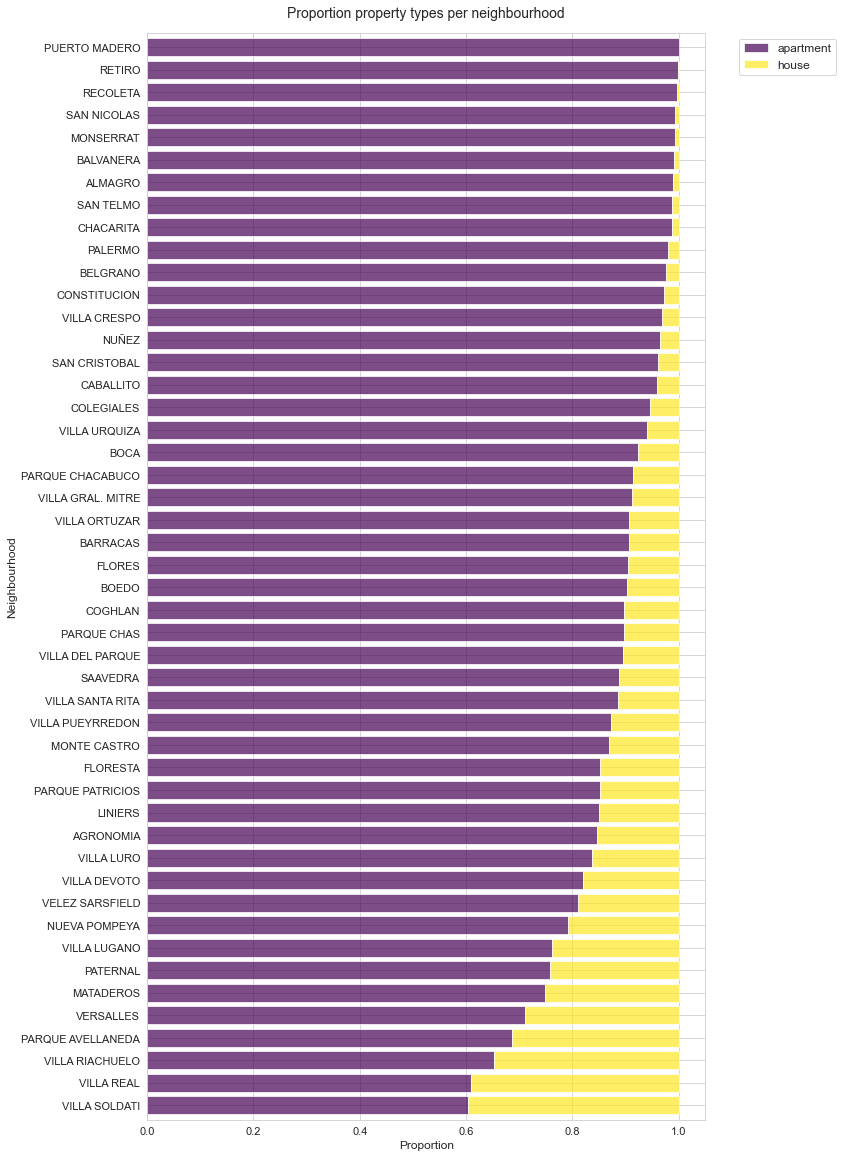

In [73]:
colors = plt.cm.viridis(np.linspace(0, 1, 2))

prop_types_nbh.drop(columns=['total']).sort_values(by='apartment').plot(kind='barh', stacked=True, width=0.8, 
                                                                        figsize=(10,20), color=colors, alpha=0.7)
plt.title('Proportion property types per neighbourhood', fontsize=14, pad=15)
plt.xlabel('Proportion', fontsize=12)
plt.ylabel('Neighbourhood', fontsize=12)
plt.yticks(fontsize=11)
plt.xticks(fontsize=11)
plt.legend(bbox_to_anchor=(1.05, 1), fontsize=12)

In [74]:
with open('properati_clean.pkl', 'wb') as f_df:
    pickle.dump(caba, f_df)